In [1]:
import os
import sys
sys.path.insert(0,os.path.join('/project/venv/lib/python3.8/site-packages/'))
sys.path.insert(0,os.path.join('/venv/lib/python3.8/site-packages'))

def ignore_user_installs(username):
    ## avoid using user installs
    user_install_path = '/scratch/' + username + '/python/lib/python3.8/site-packages'
    if user_install_path in sys.path:
        sys.path.remove(user_install_path)

ignore_user_installs("starzew")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import dill
import matplotlib as mpl
import matplotlib.patches as mpatches
import yaml
from itertools import cycle

In [3]:
def load_pkl(file_name):
    with open(file_name, 'rb') as inp:
        data = dill.load(inp)
        
    return data

In [4]:
ps = {
    "pt":{
        "asr": {
            "loss":0.2649243175983429,
            "uer":2.9758930142530353,
            "wer":10.015976871576385
        },
        "pr":{
            "loss":0.5344529151916504,
            "per":0.12702563366657632
        },
        "sid":{
            "acc":0.46988242864608765
        }
    },
    "ft":{
        "asr": {
            "loss": 0.2595512568950653,
            "uer":3.007214499384128,
            "wer":10.04070298234936
        },
        "pr":{
            "loss":0.5357611775398254,
            "per":0.12989566890423118
        },
        "sid":{
            "acc":0.47109439969062805 
        }
    }
}

In [5]:
states = {
    "asr":"dev-clean-best",
    "pr":"dev-best",
    "sid":"dev-best"
}
tasks = ["asr", "pr", "sid"]
tasks_ua = ["asr", "pr", "sid", "sev"]
tasks_ua_long = ["asr_ua","pr_ua","sid_ua", "sev_ua"]
upstreams = ["pt", "ft"]
baselines = ["spectrogram","fbank","mfcc","mel","linear"]


weights = dict()
performances = dict()
for upstream in upstreams:
    w = dict()
    p = dict()
    for task in tasks:
        infos = torch.load(f"/project/thesis/s3prl/s3prl/result/downstream/exp_{task}_{upstream}/{states[task]}.ckpt")
        w[task] = infos["Featurizer"]["weights"].cpu()
        p[task] = ps[upstream][task]
    for task in tasks_ua:
        infos = torch.load(f"/project/thesis/result/exp_{task}_{upstream}/train/valid_best/model/state_dict.pt")
        w[f"{task}_ua"] = infos["featurizer.weights"].cpu()
        if task == "pr":
            with open(f"/project/thesis/result/exp_{task}_{upstream}/evaluate/valid_best/test_asr/result_og.yaml") as f: 
                infos  = yaml.load(f, Loader=yaml.FullLoader)
        else:
            with open(f"/project/thesis/result/exp_{task}_{upstream}/evaluate/valid_best/test_{task}/result_og.yaml") as f: 
                infos  = yaml.load(f, Loader=yaml.FullLoader)
        p[f"{task}_ua"] = infos
    
    weights[upstream] = w
    performances[upstream] = p
    
for baseline in baselines:
    #print(baseline)
    p = dict()
    for task in tasks_ua: 
        #print(task)
        if task == "pr":
            with open(f"/project/thesis/result/exp_{task}_{baseline}/evaluate/valid_best/test_asr/result.yaml") as f: 
                infos  = yaml.load(f, Loader=yaml.FullLoader)
        else:
            with open(f"/project/thesis/result/exp_{task}_{baseline}/evaluate/valid_best/test_{task}/result.yaml") as f: 
                infos  = yaml.load(f, Loader=yaml.FullLoader)
        p[f"{task}_ua"] = infos
        #print(infos)
    for task in tasks:
        infos = torch.load(f"/project/thesis/s3prl/s3prl/result/downstream/exp_{task}_{upstream}/{states[task]}.ckpt")
        p[task] = ps[upstream][task]
    #print(p)
    performances[baseline] = p
        


/tmp/ipykernel_2186833/1636365062.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  infos = torch.load(f"/project/thesis/s3prl/s3prl/result/downstream/exp_{task}_{upstrea

In [6]:
performances["pt"]["asr_ua"] = {
    'loss':2.363428486851806,
    'cer':0.35254711793231014,
    'wer':0.5129298853639029
}

# Layer-wise Weights

In [7]:
def plot_weights_all2(weights, tasks, title):
    fs = 13
    px = 1/plt.rcParams['figure.dpi']
    fig, axes = plt.subplots(2,1,sharex=True)
    fig.set_figwidth(240*px)
    fig.set_figheight(4)
    
    absolute = [False,True]
    
    for i,ax in enumerate(axes):
        for task in tasks:
            if absolute[i]:
                ax.plot(np.absolute(weights["pt"][task]), label=f"{task}_pt")
                ax.plot(np.absolute(weights["ft"][task]), label=f"{task}_ft")
            else:
                ax.plot(weights["pt"][task], label=f"{task}_pt")
                ax.plot(weights["ft"][task], label=f"{task}_ft")
        ax.set_xlabel("Layer", fontsize=fs)
        #plt.xticks(fontsize=fs)
        #ax.set_box_aspect(1)
        ax.tick_params(axis='both', labelsize=fs-2)
        if absolute[i]:
            ax.set_ylabel("Absolute Weight", fontsize=fs)
        else:
            ax.set_ylabel("Weight", fontsize=fs)
        #plt.yticks(fontsize=fs)
        lines, labels = ax.get_legend_handles_labels()
    plt.figlegend(lines,labels,fontsize=fs-2,loc='upper center', bbox_to_anchor=(0.55, 1.2), ncols=3)
    fig.align_labels()
    plt.tight_layout()
    plt.savefig(f"figs/{title}.pdf", bbox_inches='tight')
    plt.show()

In [10]:
def plot_weights_both(weights, tasks, tasks_ua, title):
    fs = 13
    px = 1/plt.rcParams['figure.dpi']
    fig, ax = plt.subplots(1,2,sharex=True)
    fig.set_figwidth(480*px)
    fig.set_figheight(2.5)
    
    absolute = [True]
    
    for i in range(1):
        for j,task in enumerate(tasks):
            ax[0].plot(np.absolute(weights["pt"][tasks[j]]), label=f"{tasks[j].upper()} PT")
            ax[0].plot(np.absolute(weights["ft"][tasks[j]]), label=f"{tasks[j].upper()} FT")
            ax[1].plot(np.absolute(weights["pt"][tasks_ua[j]]), label=f"{tasks_ua[j][:-3].upper()} PT")
            ax[1].plot(np.absolute(weights["ft"][tasks_ua[j]]), label=f"{tasks_ua[j][:-3].upper()} FT")
        
        ax[1].plot(np.absolute(weights["pt"][tasks_ua[j+1]]), label=f"{tasks_ua[j+1][:-3].upper()} PT")
        ax[1].plot(np.absolute(weights["ft"][tasks_ua[j+1]]), label=f"{tasks_ua[j+1][:-3].upper()} FT")
        
        ax[0].set_xlabel("Layer", fontsize=fs)
        ax[1].set_xlabel("Layer", fontsize=fs)
        #plt.xticks(fontsize=fs)
        #ax.set_box_aspect(1)
        ax[0].tick_params(axis='both', labelsize=fs-2)
        ax[1].tick_params(axis='both', labelsize=fs-2)
        if absolute[i]:
            ax[0].set_ylabel("Abs. Weight", fontsize=fs)
        else:
            ax[0].set_ylabel("Weight", fontsize=fs)
    
    
    ax[0].set_title("SUPERB", fontsize=fs)
    ax[1].set_title("SUPERB UA",fontsize=fs)
    
    h1,l1 = ax[0].get_legend_handles_labels()
    h1 = [h1[0],h1[2],h1[4],h1[1],h1[3],h1[5]]
    l1 = [l1[0],l1[2],l1[4],l1[1],l1[3],l1[5]]
    h2,l2 = ax[1].get_legend_handles_labels()
    #h2 = [h2[0],h2[2],h2[4],h2[6],h2[1],h2[3],h2[5],h2[7]]
    #l2 = [l2[0],l2[2],l2[4],l2[6],l2[1],l2[3],l2[5],l2[7]]
    
    l2[-1] = "IDC FT"
    l2[-2] = "IDC PT"
    
    #ax[0][0].legend(h1,l1,fontsize=fs-3,loc='upper center', bbox_to_anchor=(0.5, 2), ncols=2,columnspacing=0.8)
    #ax[0][1].legend(h2,l2,fontsize=fs-3,loc='upper center', bbox_to_anchor=(0.5, 2.2), ncols=2,columnspacing=0.8)
    plt.figlegend(h2,l2,fontsize=fs-1,loc='upper center', bbox_to_anchor=(0.55, 1.25), ncols=4,columnspacing=0.8)
    fig.align_labels()
    plt.tight_layout()
    
    plt.savefig(f"figs/{title}.pdf", bbox_inches='tight')
    plt.show()

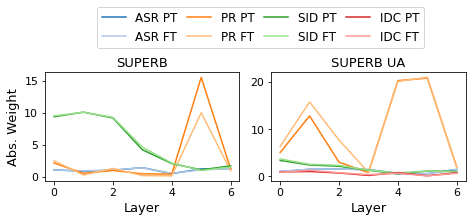

In [14]:
title ="superb_w_all"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
plot_weights_both(weights, tasks,tasks_ua_long,title)

# Performance

In [16]:
def plot_p_all(performances, title):
    px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    fig, axes = plt.subplots(2,4)
    fig.set_figwidth(500*px)
    fig.set_figheight(4.5)
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = cycle(prop_cycle.by_key()['color'])
    
    ax = axes[0][0].bar("PT", performances["pt"]["asr"]["wer"], color=next(colors))
    axes[0][0].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    ax = axes[0][0].bar("FT", performances["ft"]["asr"]["wer"], color=next(colors))
    axes[0][0].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    axes[0][0].set_ylabel("WER [%]", fontsize=13)
    axes[0][0].set_title("ASR", fontsize=13)

    ax = axes[0][1].bar("PT", performances["pt"]["pr"]["per"]*100, color=next(colors))
    axes[0][1].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    ax = axes[0][1].bar("FT", performances["ft"]["pr"]["per"]*100, color=next(colors))
    axes[0][1].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    axes[0][1].set_ylabel("PER [%]", fontsize=13)
    axes[0][1].set_title("PR", fontsize=13)

    ax = axes[0][2].bar("PT", performances["pt"]["sid"]["acc"]*100, color=next(colors))
    axes[0][2].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    ax = axes[0][2].bar("FT", performances["ft"]["sid"]["acc"]*100, color=next(colors))
    axes[0][2].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    axes[0][2].set_ylabel("Acc [%]", fontsize=13)
    axes[0][2].set_title("SID", fontsize=13)
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = cycle(prop_cycle.by_key()['color'])

    ax = axes[1][0].bar("PT", performances["pt"]["asr_ua"]["wer"]*100, color=next(colors))
    axes[1][0].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    ax = axes[1][0].bar("FT", performances["ft"]["asr_ua"]["wer"]*100, color=next(colors))
    axes[1][0].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    axes[1][0].set_ylabel("WER [%]", fontsize=13)
    axes[1][0].set_title("ASR UA", fontsize=13)

    ax = axes[1][1].bar("PT", performances["pt"]["pr_ua"]["per"]*100, color=next(colors))
    axes[1][1].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    ax = axes[1][1].bar("FT", performances["ft"]["pr_ua"]["per"]*100, color=next(colors))
    axes[1][1].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    axes[1][1].set_ylabel("PER [%]", fontsize=13)
    axes[1][1].set_title("PER UA", fontsize=13)
    
    ax = axes[1][2].bar("PT", performances["pt"]["sid_ua"]["accuracy"]*100, color=next(colors))
    axes[1][2].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    ax = axes[1][2].bar("FT", performances["ft"]["sid_ua"]["accuracy"]*100, color=next(colors))
    axes[1][2].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    axes[1][2].set_ylabel("Acc [%]", fontsize=13)
    axes[1][2].set_title("SID UA", fontsize=13)
    
    ax = axes[1][3].bar("PT", performances["pt"]["sev_ua"]["accuracy"]*100, color=next(colors))
    axes[1][3].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    ax = axes[1][3].bar("FT", performances["ft"]["sev_ua"]["accuracy"]*100, color=next(colors))
    axes[1][3].bar_label(ax, label_type='edge',fmt='{:,.1f}', fontsize=10)
    axes[1][3].set_ylabel("Acc [%]", fontsize=13)
    axes[1][3].set_title("IDC UA", fontsize=13)
    
    
    fig.delaxes(axes[0][-1])


    for ax in axes:
        for a in ax:
            a.tick_params(axis='both', which='major', labelsize=13)
            a.margins(y=0.2, x=0.15)
    fig.align_labels()
    plt.tight_layout()
    plt.savefig(f"figs/{title}.pdf")
    plt.show()

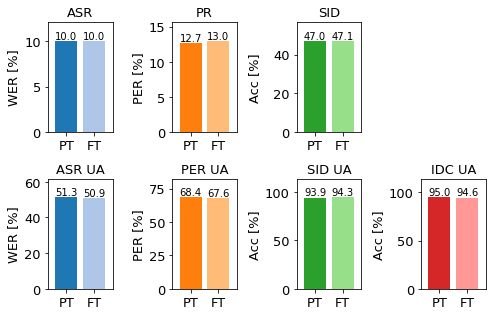

In [17]:
title="superb_performances"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)
plot_p_all(performances,title)